<a href="https://colab.research.google.com/github/eamirhn/Kaggle-Projects/blob/main/Copy_of_Brain_Tumor_Detection_Resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import userdata
import os

os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')

In [3]:
dataset_directory = "Brain Tumor Data Set/Brain Tumor Data Set"

# Check if the dataset directory exists
if not os.path.exists(dataset_directory):
    # Download the dataset
    !kaggle datasets download -d preetviradiya/brian-tumor-dataset

    # Unzip the dataset without printing output
    !unzip -qq "brian-tumor-dataset.zip"

    # Delete the zip file
    os.remove("brian-tumor-dataset.zip")
else:
    print("Dataset already exists. Skipping download and unzip steps.")

Dataset URL: https://www.kaggle.com/datasets/preetviradiya/brian-tumor-dataset
License(s): GPL-2.0
 84% 90.0M/107M [00:00<00:00, 132MB/s]
100% 107M/107M [00:00<00:00, 123MB/s] 


In [4]:
!pip install split-folders
!pip install torch-summary

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style='darkgrid')
import copy
import os
import torch
from PIL import Image # A module that Provides functionality for image file formats.
from torch.utils.data import Dataset # For accessing and processing the data during training.
import torchvision
import torchvision.transforms as transforms # A module for editing images
from torch.utils.data import random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau # A PyTorch scheduler that adjusts the learning rate during training based on a specified metric, reducing it when the metric plateaus.
import torch.nn as nn
from torchvision import utils
from torchvision.datasets import ImageFolder
import splitfolders
from torchsummary import summary
import torch.nn.functional as F
import pathlib
from sklearn.metrics import confusion_matrix, classification_report
import itertools # For efficient looping and combining of iterables.
from tqdm.notebook import trange, tqdm # For progress bars to track the progress of loops or tasks.
from torch import optim
import warnings
warnings.filterwarnings('ignore')

In [6]:
# Reading data
labels_df = pd.read_csv('/content/metadata.csv')
labels_df.head()

,Unnamed: 0,image,class,format,mode,shape
0,0,Cancer (1).jpg,tumor,JPEG,RGB,"(512, 512, 3)"
1,1,Cancer (1).png,tumor,PNG,L,"(300, 240)"
2,2,Cancer (1).tif,tumor,TIFF,RGB,"(256, 256, 3)"
3,3,Cancer (10).jpg,tumor,JPEG,RGB,"(512, 512, 3)"
4,4,Cancer (10).tif,tumor,TIFF,RGB,"(256, 256, 3)"


In [7]:
os.listdir('/content/Brain Tumor Data Set/Brain Tumor Data Set')

['Healthy', 'Brain Tumor']

In [8]:
labels_df.shape

(4600, 6)

In [9]:
# Dataset Path
data_dir = '/content/Brain Tumor Data Set/Brain Tumor Data Set'
data_dir = pathlib.Path(data_dir)

# Splitting dataset to train_set, val_set and test_set
splitfolders.ratio(data_dir, output='brain', seed=20, ratio=(0.8, 0.2))


# New dataset path
data_dir = '/content/brain'
data_dir = pathlib.Path(data_dir)

Copying files: 4600 files [00:02, 2110.23 files/s]


In [64]:
# Image Augmentation
# define transformation
transform = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomRotation(degrees=15),
        transforms.RandomAffine(degrees=10, translate=(0.05, 0.05), scale=(0.95, 1.05)),
        transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

In [65]:
# Define an object of the custom dataset for the train and validation.
train_set = torchvision.datasets.ImageFolder(data_dir.joinpath("train"), transform=transform)
train_set.transform
val_set = torchvision.datasets.ImageFolder(data_dir.joinpath("val"), transform=transform)
val_set.transform

Compose(
    Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
    RandomHorizontalFlip(p=0.5)
    RandomVerticalFlip(p=0.5)
    RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
    RandomAffine(degrees=[-10.0, 10.0], translate=(0.05, 0.05), scale=(0.95, 1.05))
    GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

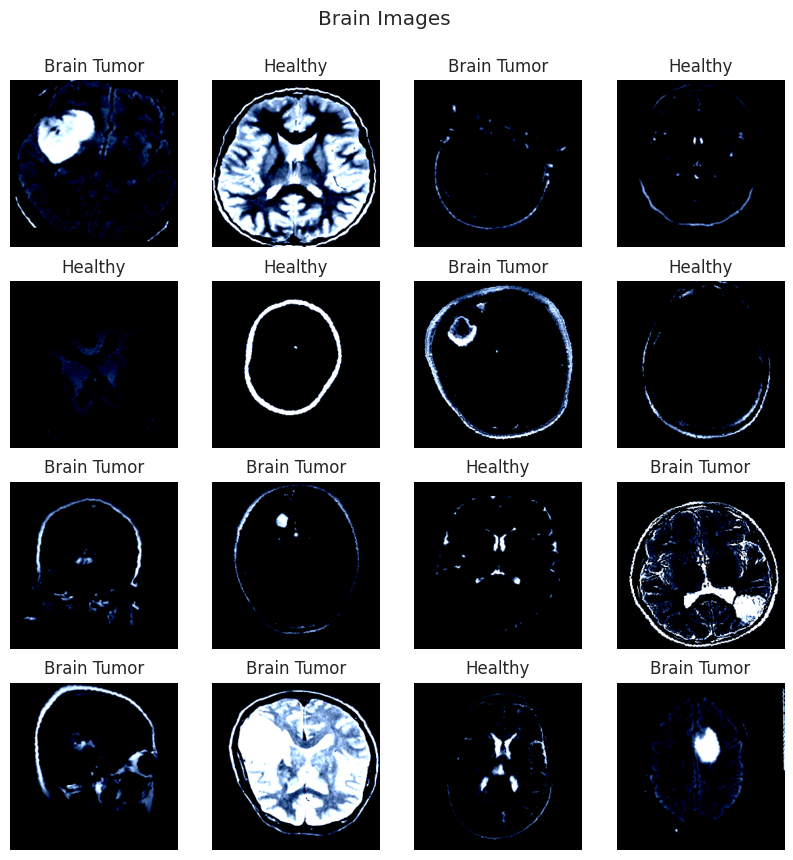

In [66]:
# Visualiztion some images from Train Set
CLA_label = {
    0 : 'Brain Tumor',
    1 : 'Healthy'
}
figure = plt.figure(figsize=(10, 10))
cols, rows = 4, 4
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_set), size=(1,)).item()
    img, label = train_set[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(CLA_label[label])
    plt.axis("off")
    img_np = img.numpy().transpose((1, 2, 0))
    # Clip pixel values to [0, 1]
    img_valid_range = np.clip(img_np, 0, 1)
    plt.imshow(img_valid_range)
    plt.suptitle('Brain Images', y=0.95)
plt.show()

In [67]:
# Data Loader
# import and load train, validation
batch_size = 64

train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size, shuffle = True, num_workers = 2)
val_loader = torch.utils.data.DataLoader(val_set, batch_size = batch_size, shuffle = True, num_workers = 2)

In [68]:
# print shape for Training data and Validation data
for key, value in {'Training data': train_loader, "Validation data": val_loader}.items():
    for X, y in value:
        print(f"{key}:")
        print(f"Shape of X : {X.shape}")
        print(f"Shape of y: {y.shape} {y.dtype}\n")
        break

Training data:
Shape of X : torch.Size([64, 3, 256, 256])
Shape of y: torch.Size([64]) torch.int64

Validation data:
Shape of X : torch.Size([64, 3, 256, 256])
Shape of y: torch.Size([64]) torch.int64



In [69]:
import torchvision.models as models

# Load the pre-trained ResNet-18 model
model = models.resnet18(pretrained=True)

In [70]:
# Freeze all the pre-trained layers
for param in model.parameters():
    param.requires_grad = False

In [71]:
# Modify the last layer of the model
num_classes =2
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)

In [72]:
def train(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    # Train the model for the specified number of epochs
    for epoch in range(num_epochs):
        # Set the model to train mode
        model.train()

        # Initialize the running loss and accuracy
        running_loss = 0.0
        running_corrects = 0

        # Iterate over the batches of the train loader
        for inputs, labels in train_loader:
            # Move the inputs and labels to the device
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Zero the optimizer gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # Backward pass and optimizer step
            loss.backward()
            optimizer.step()

            # Update the running loss and accuracy
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        # Calculate the train loss and accuracy
        train_loss = running_loss / len(train_set)
        train_acc = running_corrects.double() / len(train_set)

        # Set the model to evaluation mode
        model.eval()

        # Initialize the running loss and accuracy
        running_loss = 0.0
        running_corrects = 0

        # Iterate over the batches of the validation loader
        with torch.no_grad():
            for inputs, labels in val_loader:
                # Move the inputs and labels to the device
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # Update the running loss and accuracy
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

        # Calculate the validation loss and accuracy
        val_loss = running_loss / len(val_set)
        val_acc = running_corrects.double() / len(val_set)

        # Print the epoch results

        print('Epoch [{}/{}], train loss: {:.4f}, train acc: {:.4f}, val loss: {:.4f}, val acc: {:.4f}'
              .format(epoch+1, num_epochs, train_loss, train_acc, val_loss, val_acc))

In [73]:
# Define the loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)

# Set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Fine-tune the last layer for a few epochs
optimizer = torch.optim.SGD(model.fc.parameters(), lr=0.01, momentum=0.9)
train(model, train_loader, val_loader, criterion, optimizer, num_epochs=5)

# Unfreeze all the layers and fine-tune the entire network for a few more epochs
for param in model.parameters():
    param.requires_grad = True
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
train(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)

Epoch [1/5], train loss: 0.5553, train acc: 0.7581, val loss: 0.4423, val acc: 0.8056
Epoch [2/5], train loss: 0.4735, train acc: 0.8135, val loss: 0.3159, val acc: 0.8480
Epoch [3/5], train loss: 0.3850, train acc: 0.8481, val loss: 0.3937, val acc: 0.8426
Epoch [4/5], train loss: 0.4358, train acc: 0.8298, val loss: 0.4068, val acc: 0.8491
Epoch [5/5], train loss: 0.3309, train acc: 0.8663, val loss: 0.3880, val acc: 0.8610
Epoch [1/10], train loss: 0.2361, train acc: 0.9076, val loss: 0.1201, val acc: 0.9490
Epoch [2/10], train loss: 0.1013, train acc: 0.9638, val loss: 0.0836, val acc: 0.9707
Epoch [3/10], train loss: 0.0819, train acc: 0.9704, val loss: 0.0639, val acc: 0.9783
Epoch [4/10], train loss: 0.0551, train acc: 0.9818, val loss: 0.0571, val acc: 0.9750
Epoch [5/10], train loss: 0.0415, train acc: 0.9883, val loss: 0.0573, val acc: 0.9794
Epoch [6/10], train loss: 0.0391, train acc: 0.9872, val loss: 0.0425, val acc: 0.9891
Epoch [7/10], train loss: 0.0281, train acc: 0.9

In [47]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [74]:
torch.save(model,"/content/drive/MyDrive/brian_tumor_Resnet18_with_transforms_B.pt")

# Visualization

In [75]:
def Ture_and_Pred(val_loader, model):
    y_true = []
    y_pred = []
    incorrect_predictions = []  # Store tuples of (image, true_label, predicted_label) for incorrect predictions
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.numpy()
        outputs = model(images)
        _, pred = torch.max(outputs.data, 1)
        pred = pred.detach().cpu().numpy()

        y_true.extend(labels)
        y_pred.extend(pred)

        # Check for incorrect predictions
        incorrect_mask = pred != labels
        for idx, incorrect in enumerate(incorrect_mask):
            if incorrect:
                incorrect_predictions.append((images[idx], labels[idx], pred[idx]))

    return y_true, y_pred, incorrect_predictions

# Obtain true labels, predicted labels, and incorrect predictions
y_true, y_pred, incorrect_predictions = Ture_and_Pred(val_loader, model)


In [76]:
print(classification_report(y_true, y_pred), '\n\n')
cm = confusion_matrix(y_true, y_pred)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       503
           1       0.99      0.99      0.99       418

    accuracy                           0.99       921
   macro avg       0.99      0.99      0.99       921
weighted avg       0.99      0.99      0.99       921
 




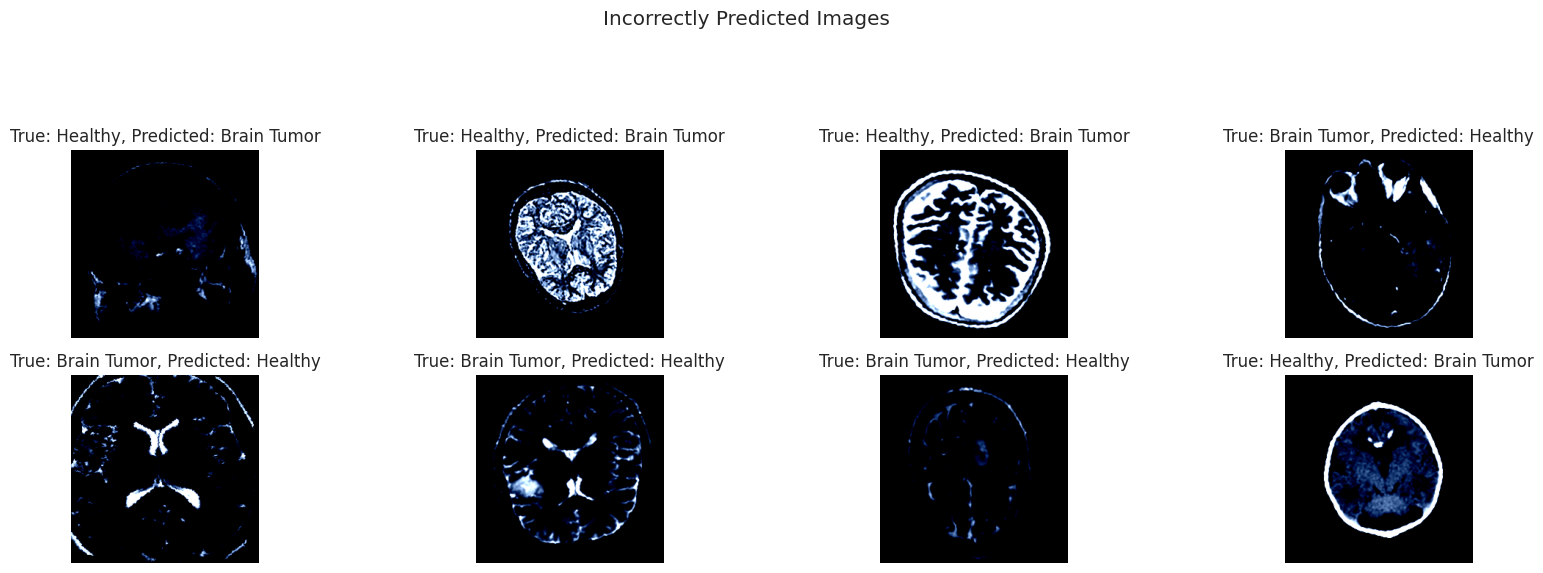

In [77]:
# Visualization of incorrectly predicted images
figure = plt.figure(figsize=(20, 20))
cols, rows = 4, 7
for i in range(1, min(cols * rows, len(incorrect_predictions)) + 1):  # Limit to the number of incorrect predictions
    img, true_label, predicted_label = incorrect_predictions[i-1]  # Get image, true label, and predicted label
    figure.add_subplot(rows, cols, i)
    plt.title(f"True: {CLA_label[true_label]}, Predicted: {CLA_label[predicted_label]}")
    plt.axis("off")
    #img_np.cpu()
    img_np = img.cpu().numpy().transpose((1, 2, 0))
    # Clip pixel values to [0, 1]
    img_valid_range = np.clip(img_np, 0, 1)
    plt.imshow(img_valid_range)
    plt.suptitle('Incorrectly Predicted Images', y=0.95)
plt.show()


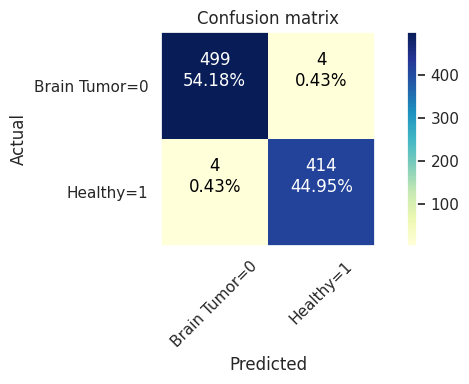

In [78]:
# Confusion Matrix Plotting Function
def show_confusion_matrix(cm, CLA_label, title='Confusion matrix', cmap=plt.cm.YlGnBu):

    plt.figure(figsize=(7,4))
    plt.grid(False)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(CLA_label))

    plt.xticks(tick_marks, [f"{value}={key}" for key , value in CLA_label.items()], rotation=45)
    plt.yticks(tick_marks, [f"{value}={key}" for key , value in CLA_label.items()])

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f"{cm[i,j]}\n{cm[i,j]/np.sum(cm)*100:.2f}%", horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.tight_layout()
    plt.show()

show_confusion_matrix(cm, CLA_label)

In [ ]:
#To save the model
#torch.save(cnn_model, "Brain_Tumor_model.pt")

# Heat Map with **[TorchCAM](https://colab.research.google.com/github/frgfm/notebooks/blob/main/torch-cam/quicktour.ipynb#scrollTo=ZvXUBQbpdADe)**

In [24]:
!pip -q install torchcam

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.5 MB/s eta 0:00:00


In [25]:
from torch.nn.functional import softmax, interpolate
from torchvision.io.image import read_image
from torchvision.models import resnet18
from torchvision.transforms.functional import normalize, resize, to_pil_image

from torchcam.methods import SmoothGradCAMpp, LayerCAM
from torchcam.utils import overlay_mask

In [79]:
#model = resnet18(pretrained=True).eval()
cam_extractor = SmoothGradCAMpp(model)

In [80]:
img = read_image("/content/Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (1037).jpg")

In [81]:
input_tensor = normalize(resize(img, (224, 224)) / 255., [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

model.to("cpu")
# Preprocess your data and feed it to the model
out = model(input_tensor.unsqueeze(0))
# Retrieve the CAM by passing the class index and the model output
cams = cam_extractor(out.squeeze(0).argmax().item(), out)

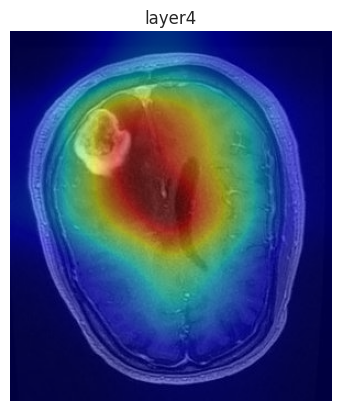

In [82]:
# Overlayed on the image
for name, cam in zip(cam_extractor.target_names, cams):
  result = overlay_mask(to_pil_image(img), to_pil_image(cam.squeeze(0), mode='F'), alpha=0.5)
  plt.imshow(result); plt.axis('off'); plt.title(name); plt.show()

tensor(1., grad_fn=<MaxBackward1>)


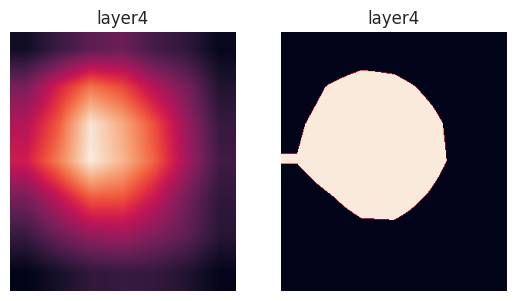

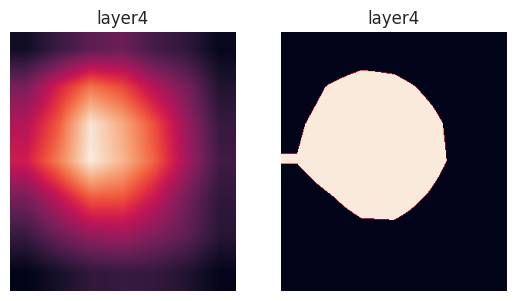

In [83]:
cam_extractor.remove_hooks()
# Retrieve the CAM from several layers at the same time
cam_extractor = LayerCAM(model)

# Preprocess your data and feed it to the model
out = model(input_tensor.unsqueeze(0))
print(softmax(out, dim=1).max())
cams = cam_extractor(out.squeeze(0).argmax().item(), out)
# Resize it
resized_cams = [resize(to_pil_image(cam.squeeze(0)), img.shape[-2:]) for cam in cams]
segmaps = [to_pil_image((resize(cam, img.shape[-2:]).squeeze(0) >= 0.5).to(dtype=torch.float32)) for cam in cams]
# Plot it
for name, cam, seg in zip(cam_extractor.target_names, resized_cams, segmaps):
  _, axes = plt.subplots(1, 2)
  axes[0].imshow(cam); axes[0].axis('off'); axes[0].set_title(name)
  axes[1].imshow(seg); axes[1].axis('off'); axes[1].set_title(name)
  plt.show()
# Resize it
resized_cams = [resize(to_pil_image(cam.squeeze(0)), img.shape[-2:]) for cam in cams]
segmaps = [to_pil_image((resize(cam, img.shape[-2:]).squeeze(0) >= 0.5).to(dtype=torch.float32)) for cam in cams]
# Plot it
for name, cam, seg in zip(cam_extractor.target_names, resized_cams, segmaps):
  _, axes = plt.subplots(1, 2)
  axes[0].imshow(cam); axes[0].axis('off'); axes[0].set_title(name)
  axes[1].imshow(seg); axes[1].axis('off'); axes[1].set_title(name)
  plt.show()

In [84]:
# Retrieve the CAM from several layers at the same time
cam_extractor = LayerCAM(model, ["layer2", "layer3", "layer4"])

# Preprocess your data and feed it to the model
out = model(input_tensor.unsqueeze(0))
# Retrieve the CAM by passing the class index and the model output
cams = cam_extractor(out.squeeze(0).argmax().item(), out)

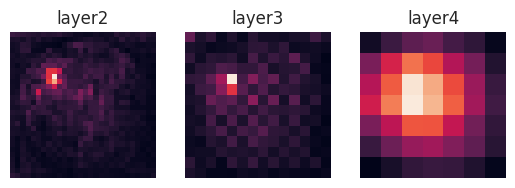

In [85]:
# The raw CAM
_, axes = plt.subplots(1, len(cam_extractor.target_names))
for idx, name, cam in zip(range(len(cam_extractor.target_names)), cam_extractor.target_names, cams):
  axes[idx].imshow(cam.squeeze(0).numpy()); axes[idx].axis('off'); axes[idx].set_title(name);
plt.show()

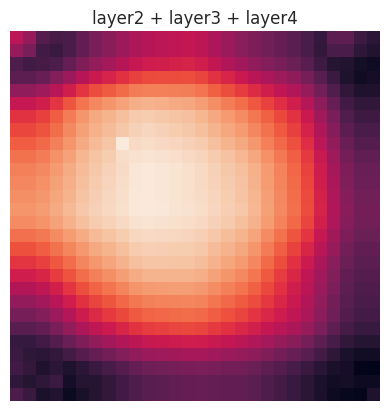

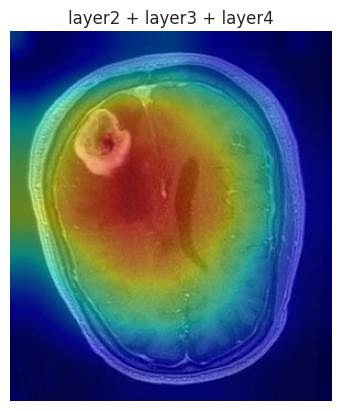

In [86]:
# Let's fuse them
fused_cam = cam_extractor.fuse_cams(cams)
# Plot the raw version
plt.imshow(fused_cam.squeeze(0).numpy()); plt.axis('off'); plt.title(" + ".join(cam_extractor.target_names)); plt.show()
# Plot the overlayed version
result = overlay_mask(to_pil_image(img), to_pil_image(fused_cam, mode='F'), alpha=0.5)
plt.imshow(result); plt.axis('off'); plt.title(" + ".join(cam_extractor.target_names)); plt.show()

In [87]:
# Once you're finished, clear the hooks on your model
cam_extractor.remove_hooks()

# Feature Extraction

In [38]:
from skimage import measure

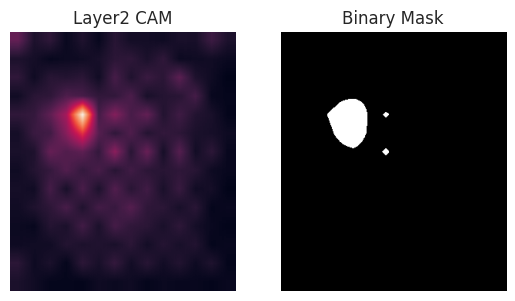

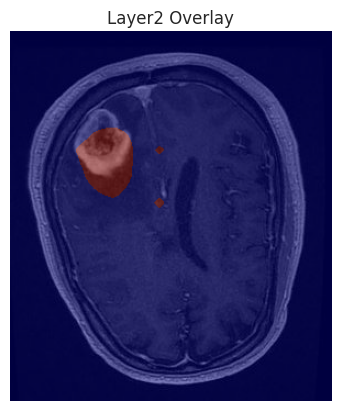

In [123]:
cam_extractor = LayerCAM(model, ["layer3","layer2","layer4"])
out = model(input_tensor.unsqueeze(0))

# Retrieve CAM for layer2
cams = cam_extractor(out.squeeze(0).argmax().item(), out)

# Use only the first CAM, which corresponds to layer2
layer2_cam = cams[0]

# Resize and apply threshold to CAM
threshold = 0.3
resized_cam = resize(to_pil_image(layer2_cam.squeeze(0)), img.shape[-2:])
binary_mask = (resize(layer2_cam, img.shape[-2:]).squeeze(0) >= threshold).to(dtype=torch.float32)

# Plot CAM and binary mask
_, axes = plt.subplots(1, 2)
axes[0].imshow(resized_cam); axes[0].axis('off'); axes[0].set_title('Layer2 CAM')
axes[1].imshow(binary_mask, cmap='gray'); axes[1].axis('off'); axes[1].set_title('Binary Mask')
plt.show()

# Overlay binary mask on image
result = overlay_mask(to_pil_image(img), to_pil_image(binary_mask, mode='F'), alpha=0.5)
plt.imshow(result); plt.axis('off'); plt.title('Layer2 Overlay'); plt.show()

# Clear hooks
cam_extractor.remove_hooks()

In [120]:
from torchcam.methods import LayerCAM
from torchvision.transforms.functional import to_pil_image
from torchvision.transforms import Resize
from skimage.measure import label, regionprops
from scipy.ndimage import binary_fill_holes
import matplotlib.pyplot as plt
import torch

def optimize_cam_extraction(model, input_tensor, img):
    cam_extractor = LayerCAM(model, ["layer3"])

    # Forward pass
    out = model(input_tensor.unsqueeze(0))

    # Retrieve CAM for the most relevant class
    class_id = out.squeeze(0).argmax().item()
    cams = cam_extractor(class_id, out)

    # Use CAM from the specified layer
    cam = cams[0]

    # Resize CAM to match original image dimensions
    resized_cam = Resize(img.shape[-2:])(to_pil_image(cam.squeeze(0)))

    # Apply adaptive thresholding
    threshold = cam.max() * 0.3  # Dynamic threshold
    binary_mask = (cam.squeeze(0) >= threshold).to(dtype=torch.float32)

    # Keep only the largest connected component
    labeled_mask = label(binary_mask.cpu().numpy())
    regions = regionprops(labeled_mask)
    if regions:
        largest_region = max(regions, key=lambda r: r.area)
        largest_region_mask = labeled_mask == largest_region.label

        # Fill holes in the region to make the shape more continuous
        binary_mask = torch.tensor(binary_fill_holes(largest_region_mask), dtype=torch.float32)
    else:
        binary_mask = torch.zeros_like(binary_mask)  # Return an empty mask if no regions found

    # Convert to PIL images for visualization
    resized_mask = Resize(img.shape[-2:])(to_pil_image(binary_mask, mode='F'))

    # Overlay CAM and binary mask on the original image
    overlay_result = overlay_mask(to_pil_image(img), resized_mask, alpha=0.6)

    # Visualization
    _, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(resized_cam); axes[0].axis('off'); axes[0].set_title('CAM')
    axes[1].imshow(binary_mask, cmap='gray'); axes[1].axis('off'); axes[1].set_title('Binary Mask')
    axes[2].imshow(overlay_result); axes[2].axis('off'); axes[2].set_title('Overlay')
    plt.tight_layout()
    plt.show()

    # Extract tumor shape features
    labeled_tumor = label(binary_mask.cpu().numpy())
    tumor_properties = regionprops(labeled_tumor)

    shape_features = []
    for prop in tumor_properties:
        shape_features.append({
            'area': prop.area,
            'perimeter': prop.perimeter,
            'eccentricity': prop.eccentricity,
            'solidity': prop.solidity
        })

    # Clear hooks
    cam_extractor.remove_hooks()

    return binary_mask, shape_features

# Call the function (example usage)
# binary_mask, shape_features = optimize_cam_extraction(model, input_tensor, img)

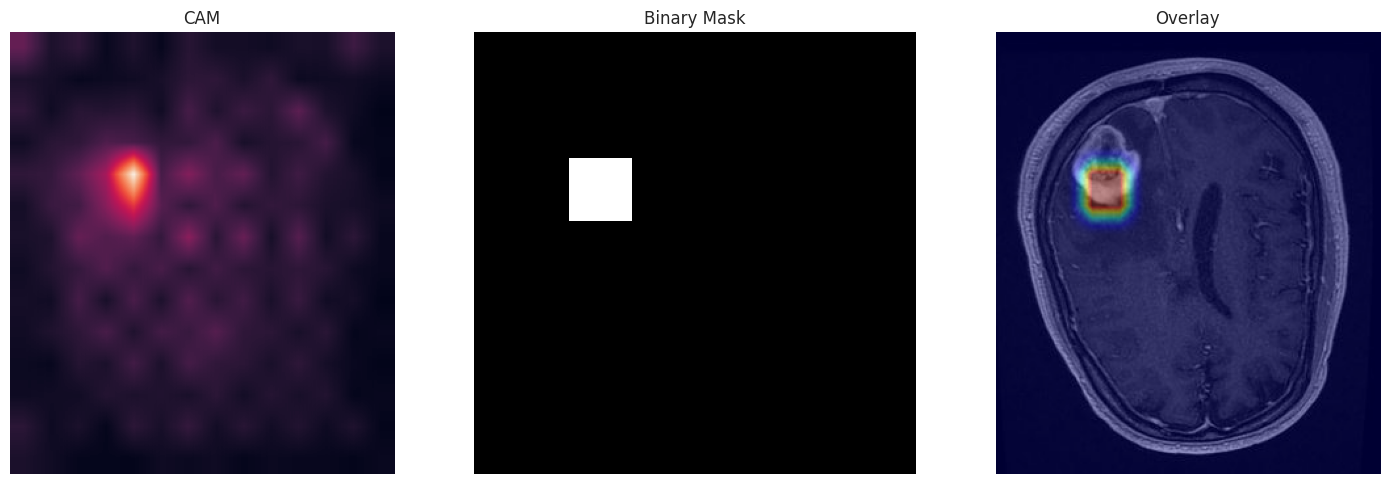

In [122]:
binary_mask2, shape_features = optimize_cam_extraction(model, input_tensor, img)

In [124]:
# Assuming you have a segmented tumor region stored in the variable 'tumor_mask'
tumor_mask = binary_mask
labeled_tumor = measure.label(tumor_mask)
tumor_properties = measure.regionprops(labeled_tumor)

shape_features = []
for prop in tumor_properties:
    shape_features.append({
        'area': prop.area,
        'perimeter': prop.perimeter,
        'eccentricity': prop.eccentricity,
        'solidity': prop.solidity
    })

In [125]:
tumor_mask.unique()

tensor([0., 1.])

In [126]:
from PIL import Image
from scipy import stats

# Ensure tumor_mask is a boolean tensor
tumor_mask = tumor_mask.bool()

# Expand the mask to match the image dimensions
tumor_mask_expanded = tumor_mask.unsqueeze(0).expand_as(img)

# Extract tumor intensities
tumor_intensities = img[tumor_mask_expanded].cpu().numpy()


first_order_features = {
    'mean': np.mean(tumor_intensities),
    'std_dev': np.std(tumor_intensities),
    'skewness': stats.skew(tumor_intensities),
    'kurtosis': stats.kurtosis(tumor_intensities)
}

In [127]:
pip -q install pyradiomics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 53.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 23.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 103.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.4/52.4 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.5/117.5 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 722.2/722.2 kB 52.3 MB/s eta 0:00:00


In [128]:
import SimpleITK as sitk
import numpy as np
from radiomics import featureextractor
import six

def prepare_data(img, tumor_mask):
    # Convert PyTorch tensor to NumPy array
    tumor_image_np = img.cpu().numpy().transpose(1, 2, 0)

    # Convert PIL Image to NumPy array
    tumor_mask_np = np.array(tumor_mask)

    # Ensure the image is grayscale
    if tumor_image_np.shape[-1] == 3:
        tumor_image_gray = np.mean(tumor_image_np, axis=-1)
    else:
        tumor_image_gray = tumor_image_np.squeeze()

    # Ensure the mask is binary
    tumor_mask_np = (tumor_mask_np > 0).astype(np.uint8)

    print("Image shape:", tumor_image_gray.shape)
    print("Mask shape:", tumor_mask_np.shape)
    print("Image dtype:", tumor_image_gray.dtype)
    print("Mask dtype:", tumor_mask_np.dtype)
    print("Unique values in mask:", np.unique(tumor_mask_np))

    return tumor_image_gray, tumor_mask_np

def convert_to_sitk(image_np, mask_np):
    image_sitk = sitk.GetImageFromArray(image_np.astype(np.float32))

    # Convert mask to SimpleITK image using a different method
    mask_sitk = sitk.GetImageFromArray(mask_np)
    mask_sitk = sitk.Cast(mask_sitk, sitk.sitkUInt8)

    print("Unique values in SimpleITK mask:", np.unique(sitk.GetArrayFromImage(mask_sitk)))

    return image_sitk, mask_sitk

def init_feature_extractor():
    settings = {
        'binWidth': 25,
        'resampledPixelSpacing': None,
        'interpolator': sitk.sitkBSpline
    }
    return featureextractor.RadiomicsFeatureExtractor(**settings)

def extract_features(extractor, image_sitk, mask_sitk):
    try:
        result = extractor.execute(image_sitk, mask_sitk)
        return result
    except Exception as e:
        print("Error during feature extraction:", str(e))
        return None

# Main execution
try:
    # Prepare data
    image_np, mask_np = prepare_data(img, tumor_mask)

    # Convert to SimpleITK
    image_sitk, mask_sitk = convert_to_sitk(image_np, mask_np)

    # Initialize extractor
    extractor = init_feature_extractor()

    # Extract features
    result = extract_features(extractor, image_sitk, mask_sitk)

    if result:
        print("Extracted features:")
        for key, value in six.iteritems(result):
            print("\t", key, ":", value)
    else:
        print("Feature extraction failed.")
except Exception as e:
    print("An error occurred:", str(e))


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Applying custom setting overrides: {'binWidth': 25, 'resampledPixelSpacing': None, 'interpolator': 23}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
INFO:radiomics.featureextractor:

Image shape: (337, 293)
Mask shape: (337, 293)
Image dtype: float64
Mask dtype: uint8
Unique values in mask: [0 1]
Unique values in SimpleITK mask: [0 1]
Extracted features:
	 diagnostics_Versions_PyRadiomics : v3.0.1
	 diagnostics_Versions_Numpy : 1.26.4
	 diagnostics_Versions_SimpleITK : 2.4.0
	 diagnostics_Versions_PyWavelet : 1.8.0
	 diagnostics_Versions_Python : 3.10.12
	 diagnostics_Configuration_Settings : {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 23, 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True, 'binWidth': 25}
	 diagnostics_Configuration_EnabledImageTypes : {'Original': {}}
	 diagnostics_Image-original_Hash : 0de7a8e869af403c486097bb4fe4d74aa9ef42af
	 diagnostics_Image-original_Dimensionality : 2D
	 diagnostics_Image-original_Spacing : (1.0, 1.0)
	 d

In [129]:
all_features = {**shape_features[0], **first_order_features}